# Collaborative filtering

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as scsp

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

## Analyzing the given ratings dataset
Show graphs in which the characteristics of the ratings are shown:
1. Distribution of how often a movie is rated
2. Distribution of how often a specific rating was given
3. Distribution of the average ratings given to a movie
4. Distribution of the average ratings given by the users
5. Something you want to learn from the data set

The following files are going to be used for plotting these graphs:
- Movie info: `movies.csv`
  - `movieId, title, genres`
- Movie ratings by users: `ratings.csv`
  - `userId, movieId, rating, timestamp`

In [7]:
movies = pd.read_csv('./dataset/movies.csv')
ratings = pd.read_csv('./dataset/ratings.csv')

In [8]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [9]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


### 1. Distribution of how often a movie is rated

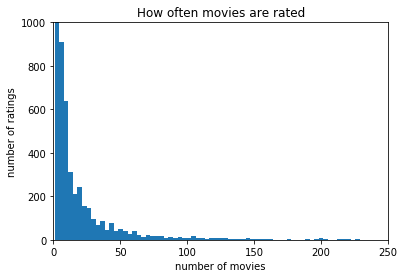

In [10]:
rate_count = ratings[['movieId', 'rating']].groupby('movieId').count()
_ = rate_count.plot.hist(bins=100, title='How often movies are rated', xlim=(0, 250), ylim=(0, 1000), legend=False).set(xlabel='number of movies', ylabel='number of ratings')

### 2. Distribution of how often a specific rating was given

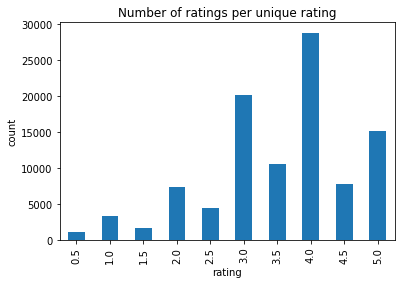

In [11]:
specific_rate_count = ratings[['rating', 'movieId']].groupby('rating').count()
_ = specific_rate_count.plot(kind='bar', title='Number of ratings per unique rating', legend=False).set_ylabel('count')

### 3. Distribution of the average ratings given to a movie

This shows that an average rating for a movie of 3.5 - 4.0 occurs most.

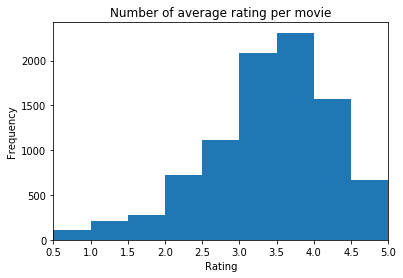

In [12]:
avg_movie_ratings = ratings[['movieId', 'rating']].groupby('movieId').mean()
_ = avg_movie_ratings.plot.hist(bins=9, xlim=(0.5, 5), title='Number of average rating per movie', legend=False).set_xlabel('Rating')

### 4. Distribution of the average ratings given by the users

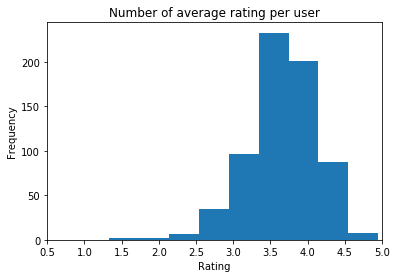

In [13]:
avg_user_ratings = ratings[['userId', 'rating']].groupby('userId').mean()
_ = avg_user_ratings.plot.hist(bins=9, xlim=(0.5, 5), title='Number of average rating per user', legend=False).set_xlabel('Rating')

### 5. Something you want to learn from the data set

In [14]:
# helemaal niks geak

## User-item matrix

A table with every rating from every user for every movie. We use a sparse matrix, because there will be alot of 'empty' ratings.

```
structure:
   /      movieids
userids   ratings

example:
   /      0,   1,   2
   0      0.5  4.0  0.0
   1      0.0  1.0  2.5
   2      1.5  5.0  3.5
```

In the example above, user 0 rated movie 0 with 0.5 (stars) and user 2 rated movie 1 with 5 (starts).

Because the user and movie ids in the provided data start at 0, the 0th indices are always `0.0`. Therefore: `shape=(row.max() + 1, col.max() + 1)`.

In [15]:
user_item_df = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
item_user_df = ratings.pivot(index='movieId', columns='userId', values='rating')
item_user_df.head(10)

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## User-user matrix

A table with the similiarity of every user to every user.

Derive user-user similarity matrices based on:

1. Cosine similarity
2. Pearson similarity
3. Adjusted cosine similarity

and give N (configurable) recommendations for a given user U (configurable) derived from the ratings of the 10 most similar users for each of these similarities.

Note:

- Because every user is perfectly similar to themselves, a diagonal line of 'perfect' `1.0` scores occurs from the top left to the bottom right.

### 1. Cosine similarity

Cosine angle distance between items.

In [11]:
cosine_user_user_matrix = cosine_similarity(user_item_df.fillna(0))
cosine_user_user_matrix

array([[1.        , 0.        , 0.        , ..., 0.06291708, 0.        ,
        0.01746565],
       [0.        , 1.        , 0.12429498, ..., 0.02413984, 0.17059464,
        0.1131753 ],
       [0.        , 0.12429498, 1.        , ..., 0.08098382, 0.13660585,
        0.17019275],
       ...,
       [0.06291708, 0.02413984, 0.08098382, ..., 1.        , 0.04260878,
        0.08520194],
       [0.        , 0.17059464, 0.13660585, ..., 0.04260878, 1.        ,
        0.22867673],
       [0.01746565, 0.1131753 , 0.17019275, ..., 0.08520194, 0.22867673,
        1.        ]])

### 2. Pearson similarity

Cosine angle distance between items.

Values are first centered around zero by subtracting the row average from it.

In [12]:
centered_user_item_df = user_item_df.copy().fillna(0)
centered_user_item_df[centered_user_item_df > 0] -= ratings.groupby('userId').mean().rating
centered_user_item_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.304348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.304348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00,0.0,0.431373,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.45,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.695652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.45,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
pearson_user_user_matrix = cosine_similarity(centered_user_item_df.fillna(0))
pearson_user_user_matrix

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.0237917 , ..., -0.0399751 ,
        -0.02547613,  0.18621763],
       [ 0.        ,  0.0237917 ,  1.        , ...,  0.        ,
         0.08553503,  0.32007013],
       ...,
       [ 0.        , -0.0399751 ,  0.        , ...,  1.        ,
         0.        ,  0.17258017],
       [ 0.        , -0.02547613,  0.08553503, ...,  0.        ,
         1.        ,  0.33834572],
       [ 0.        ,  0.18621763,  0.32007013, ...,  0.17258017,
         0.33834572,  1.        ]])

### 3. Adjusted cosine similarity

In [14]:
centered_item_user_df = user_item_df.copy().fillna(0)
centered_item_user_df[centered_item_user_df > 0] -= ratings.groupby('movieId').mean().rating
centered_item_user_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.54918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.54918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00000,0.0,0.838983,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.87247,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.45082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.12753,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
adj_cosine_user_user_matrix = cosine_similarity(centered_item_user_df.fillna(0))
adj_cosine_user_user_matrix

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.32912125e-05,  0.00000000e+00,  2.11580376e-02],
       [ 0.00000000e+00,  1.00000000e+00,  2.63859246e-02, ...,
        -1.15523154e-02, -1.15511874e-01,  4.29469128e-02],
       [ 0.00000000e+00,  2.63859246e-02,  1.00000000e+00, ...,
         1.03936243e-01, -4.03217819e-02, -1.32612524e-03],
       ...,
       [ 2.32912125e-05, -1.15523154e-02,  1.03936243e-01, ...,
         1.00000000e+00,  5.34878173e-02,  3.94096061e-02],
       [ 0.00000000e+00, -1.15511874e-01, -4.03217819e-02, ...,
         5.34878173e-02,  1.00000000e+00,  1.10190941e-02],
       [ 2.11580376e-02,  4.29469128e-02, -1.32612524e-03, ...,
         3.94096061e-02,  1.10190941e-02,  1.00000000e+00]])

## Recommend Movies Using Similiar Users

`matrix[user]` gives the similiarities

In [56]:
def get_similiar_users(user_user_matrix, user_id, n_users=10):
    """
    Get the n_users most similiar users according to the provided user-user-matrix.
    Returned list includes the user_id provided.
    
    User ids start at 1 and in the below dataframe at 0. This is corrected before returning the list.
    """
    user_user_df = pd.DataFrame(user_user_matrix.copy())
    return user_user_df.loc[user_id - 1].sort_values(ascending=False).index[:n_users+1] + 1

def recommend_movies(user_item_df, user_ids, n_movies=10):
    """
    
    """
    user_id = similiar_users[0]
    similiar_user_ids = similiar_users[1:]
    similiar_df = user_item_df.loc[user_ids]
    movie_ids = set()
    for u_id in similiar_user_ids:
        movie_ids.update(similiar_df.loc[u_id][similiar_df.loc[u_id].notna()].index)
    for m_id in similiar_df.loc[user_id][similiar_df.loc[user_id].notna()].index:
        movie_ids.discard(m_id)
    return list(movie_ids)[:n_movies]

In [69]:
similiar_users = get_similiar_users(user_user_matrix=pearson_user_user_matrix, user_id=5)
similiar_users

Int64Index([5, 646, 473, 653, 275, 402, 127, 442, 623, 238, 145], dtype='int64')

In [70]:
recommended_movies = recommend_movies(user_item_df=user_item_df, user_ids=similiar_users)
recommended_movies

[1, 2, 122882, 2053, 2054, 122886, 69640, 5, 10, 11]

In [1]:
movies[movies.movieId.isin(recommended_movies)]

NameError: name 'movies' is not defined

## Item-item collaborative filtering
1. Take the K highest rated items of a user
2. Find similar items
3. For each similar item that has not been seen by the user, calculate the expected rating (Weighted arithmetic mean)
4. Select the top N movies with the highest rating

In [31]:
def get_highest_rated_items(user_id, df, k_items=5):
    return df.loc[:,user_id].sort_values(ascending=False).index[:k_items]

In [33]:
k_heightest_rated_movies = get_highest_rated_items(1, item_user_df)

In [35]:
centered_item_user_df = item_user_df.copy().fillna(0)
centered_item_user_df[centered_item_user_df > 0] -= ratings.groupby('movieId').mean().rating
pearson_item_item_matrix = cosine_similarity(centered_item_user_df.fillna(0))
pearson_item_item_matrix

array([[1.        , 0.14299482, 0.11919446, ..., 0.        , 0.        ,
        0.02814709],
       [0.14299482, 1.        , 0.02365236, ..., 0.        , 0.        ,
        0.        ],
       [0.11919446, 0.02365236, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02814709, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
pearson_item_item_matrix[pearson_item_item_matrix == 0] = (w1 * x1 + w2 * x2) / (w1 + w2)